## From dataset to patterns

### Save compy.py (Pancho) to use in this notebook

In [ ]:
%%writefile compy.py 
#__version__ = "0.1.0"
#__author__ = 'Francisco Iaconis, Jessica Del Punta, Adrian Jimenez Gandica'
#__credits__ = 'UNS - CONICET'

import pandas as pd
import glob
from itertools import permutations
import numpy as np
import matplotlib.pyplot as plt
import itertools
import scipy.signal as sg

def Npattern(permdf,D,*arg):
    distx = get_patterns(arg[0],D,permdf)
    distx.columns = ['pat_pattern',arg[0].name]
    if len(arg)>1:
        for a in arg[1:]:
            disty = get_patterns(a,D,permdf)
            disty.columns = ['pat_pattern',a.name]
            distx = pd.merge(distx,disty,how ="outer",on = "pat_pattern") # Uno las distribuciones en un solo dataframe
    return(distx)

def patterns(filename,D,root):# D es el ws, el tamaño de la ventana
    
    permdf = make_patterns(D) # Fabrico los patrones. Funcion que se explica a continuacion
    
    for archivo in filename: # para cada elemento en "filename" hacer lo siguiente:    
        dft = pd.read_csv(archivo) # se l

    ## Por archivo voy comparando la serie temoral con los patrones. Esto lo hago con la funcion "get_patterns("serie temporal",'d' de patterns)"
        try:
            dist = pd.DataFrame()
            # saco la distribucion de probabilidades para 'x' y para 'y'
            disty = get_patterns(dft['y'],D,permdf)
            distx = get_patterns(dft['x'],D,permdf)
            
            dist = pd.merge(distx,disty,how ="outer",on = "pat_pattern") # Uno las distribuciones en un solo dataframe
            dist.columns = ['pattern','x','y'] # Asigno nombres a las columnas

            #tiempo_total = dft["t"].iloc[-1]  # Calculo el tiempo total del test
            f = archivo
            n = min([f[::-1].find('/'),f[::-1].find('\\')]) # esto es para encontrar la ultima barra del file
            archivo = f[-n:-4]# El nombre del file solamente
            #dist.to_csv(("..//Complejidad - Datos/Distribuciones/"+archivo+'_t'+str(int(tiempo_total/1000))+"_"+str(D)+"_patterns.csv"),index = False) #guardo las distribuciones en archivos
            dist.to_csv((root+archivo+"_D"+str(D)+"_patterns.csv"),index = False) #guardo las distribuciones en archivos
        except:
            print("Error en el archivo "+archivo+". No se pudo calcular los patrones por alguna razon")

def make_patterns(d):
    ''' 
    Esta funcion crea los patrones de 'd' puntos
    '''
    listname = []
    v = range(0,d) # esto me da una lista que va de cero a d-1
    perm = permutations(v) # calculo todas las permutaciones
    permdf = pd.DataFrame(list(perm)) #las pongo en un dataframe ordenadas. cada fila es una permutacion y cada columna es una posicion
    for i in range(1,d+1):
        listname.append("x"+str(i))
    permdf.columns=listname# la columnas se llaman ['x1','x2','x3']
    
    permdf = permdf.astype(str)
    permdf["pat_pattern"] = permdf["x1"]
    
    for i in range(2,d+1):
        permdf["pat_pattern"] = permdf["pat_pattern"]+permdf["x"+str(i)] # esto es para que me queden los patrones en una columna 

    return (permdf)

def get_patterns(dfx,d,permdf):
    tempdf = pd.DataFrame()
    tempdf["x1"]=dfx #dft['x']
    for i in range(1,d):
        tempdf["x"+str(i+1)]=dfx.shift(-i) 

    # Borro los primeros puntos que me quedan con NaN
    tempdf = tempdf.drop(tempdf.tail(d-1).index)#,inplace=True)
    
    sort_index = np.argsort(tempdf) # Esto me da directamente el patron. me ordena de menos a mayor y me da el indice (excelente!!!!)
    sortdf = pd.DataFrame(sort_index) # Lo convierto a dataframe
    sortdf = sortdf.astype(str)
    
    sortdf["pat_pattern"] = sortdf["x1"]
    for j in range(2,d+1):
        sortdf["pat_pattern"] = sortdf["pat_pattern"]+sortdf["x"+str(j)]

    sortdf["cant"] = 1
    sortdfgroup = sortdf.groupby("pat_pattern")
    pattDist = sortdfgroup.sum()/sortdfgroup.sum().sum()
    pattDist.reset_index(level=0, inplace=True)
    
    pattdistFull = pd.DataFrame()
    #pattdistFull = pd.merge(pattDist,permdf,how ="outer",on = "pat_pattern")
    pattdistFull = pd.merge(permdf,pattDist,how ="outer",on = "pat_pattern")
    pattdistFull = pattdistFull.fillna(0.0)
    pattDist1 = pattdistFull[["pat_pattern","cant"]]
    
    return(pattDist1)

def pattern_mod(filename,s,points,root):

    patterns_base = make_patt_dir(points)
    for archivo in filename: # para cada elemento en "filename" hacer lo siguiente:    
        dft = pd.read_csv(archivo)

    ## Por archivo voy comparando la serie temoral con los patrones. Esto lo hago con la funcion "get_patterns("serie temporal",'d' de patterns)"
        try:
            dist = pd.DataFrame()
            dist,ur = get_pattern_mod(dft,s,points,archivo,patterns_base) # Esta funcion es la que obtiene las distribuciones a partir de la señal
            
            f = archivo
            n = min([f[::-1].find('/'),f[::-1].find('\\')]) #Doy vuelta el nombre y busco donde esta la barra. Esta posicion con signo menos es la que me dice donde empuieza el nombre del file
            archivo = f[-n:-4]# El nombre del file solamente
            
            dist.to_csv((root+archivo+"_points"+str(points)+"_s"+str(s)+"_pattern_mod.csv"),index = False) #guardo las distribuciones en archivos
        except:
            print("Error en el archivo "+archivo+". No se pudo calcular los patrones por alguna razon")

def make_patt_dir(points):
    patternr =pd.DataFrame(list(itertools.product(('L','R','U','D','S'), repeat=points)))
    patternr['pattern'] = patternr[0] 
    for i in patternr.columns:
       # print i
        try:
            patternr['pattern'] = patternr['pattern']+patternr[i+1] 
        except:
            pass
    return(patternr)

def Npatt_mod(ws,patternr,datax,datay,diff_umbral):
     # calculo el desplazamiento punto a punto "r", solo para obtener un valor de umbral para definir el estado "stay"
    df_temp = pd.DataFrame({'x':datax,
                           'y':datay})
    df_temp['x_next'] = df_temp['x'].shift(-1)
    df_temp['y_next'] = df_temp['y'].shift(-1)
    df_temp['rx'] = df_temp['x_next'] - df_temp['x']
    df_temp['ry'] = df_temp['y_next'] - df_temp['y']
    df_temp['r'] =  np.sqrt(df_temp['rx']**2+df_temp['ry']**2)
    
    dft = df_temp.copy()
    # Defino las direcciones
    dft['dir'] = 0
    dft['dir'] = dft['dir'].mask((dft['ry']/dft['rx'] < 1) & (dft['ry']/dft['rx'] > -1) & (dft['rx'] > 0),'L')
    dft['dir'] = dft['dir'].mask((dft['ry']/dft['rx'] < 1) & (dft['ry']/dft['rx'] > -1) & (dft['rx'] < 0),'R')
    dft['dir'] = dft['dir'].mask(((dft['ry']/dft['rx'] < -1) | (dft['ry']/dft['rx'] > 1)) & (dft['ry'] > 0),'U')
    dft['dir'] = dft['dir'].mask(((dft['ry']/dft['rx'] < -1) | (dft['ry']/dft['rx'] > 1)) & (dft['ry'] < 0),'D')
    
    diff_umbral_value = dft.r.quantile(diff_umbral)
    dft['dir'] = dft['dir'].mask(dft['r']<=diff_umbral_value,'S')

    dft['dir0'] = dft['dir']
    del dft['dir']
    
    # no tengo idea del por qué de esto pero por alguna razon lo puse
    for i in range(ws-1):
        dft['dir'+str(i+1)] = dft['dir'+str(i)].shift(-1)
    dft = dft[1*ws:]
    dft = dft[:-ws*1]

    dft['patt_mod'] = dft['dir0']
    for i in range(1,ws):
        dft['patt_mod'] = dft['patt_mod'] + dft['dir'+str(i)]


    grouped_patt = dft.groupby("patt_mod")
    
    patt_mod_dist = pd.DataFrame()
    
    for group in grouped_patt.groups:
        patt_cant = pd.DataFrame([ [group , len(grouped_patt.groups[group])] ])
        patt_mod_dist = pd.concat([patt_mod_dist,patt_cant])
    
    patt_mod_dist.columns = ['pattern','cant']
    patt_mod_dist['cant'] = patt_mod_dist['cant']/patt_mod_dist['cant'].sum() 

    patt_mod_dist = patt_mod_dist.reset_index(drop=True)
    new_index = list(range(len(patt_mod_dist)))

    patt_mod_dist.reindex(new_index)
    patt_tot = pd.merge(patternr,patt_mod_dist,how = 'left', on ='pattern' )
    #patt_tot = pd.merge(patt_mod_dist,patternr,how = 'left', on ='pattern' )
    patt_tot = patt_tot.fillna(0)
    patt_tot = patt_tot[['pattern','cant']]
    return (patt_tot)

def get_pattern_mod(dft,s,points,archivo,patternr):
    '''
    dft: DataFrame de datos
    s: parametro de subsampleo
    points: cuantos puntos forman los patrones (windows size)
    archivo: nombre del file a evaluar
    patternr: posibles patrones
    '''
    # calculo el desplazamiento punto a punto "r", solo para obtener un valor de umbral para definir el estado "stay"
    df_temp = dft.copy()
    df_temp['x_next'] = df_temp['x'].shift(-1)
    df_temp['y_next'] = df_temp['y'].shift(-1)
    df_temp['rx'] = df_temp['x_next'] - df_temp['x']
    df_temp['ry'] = df_temp['y_next'] - df_temp['y']
    df_temp['r'] =  np.sqrt(df_temp['rx']**2+df_temp['ry']**2)
    
    # Defino un umblar para determinar cuando el sujeto esta realizando una fijacion
    if 'CARAS' in archivo: 
        ur  = float(df_temp['r'].quantile([0.85]))
    elif 'TMT' in archivo:
        ur  = float(df_temp['r'].quantile([0.75]))
    else:
        ur  = float(df_temp['r'].quantile([0.8])) # Este porcentaje es arbitrario, podria ser distinto
        
    dft = sub_samp(dft,s,'dec') # esta funcion subsamplea la señal
    # Vuelvo a calcular el desplazamiento parcial con la señal subsampleada
    
    dft['x_next'] = dft['x'].shift(-1)
    dft['y_next'] = dft['y'].shift(-1)
    dft['rx'] = dft['x_next'] - dft['x']
    dft['ry'] = dft['y_next'] - dft['y']
    dft['r'] =  np.sqrt(dft['rx']**2+dft['ry']**2)
    # Defino las direcciones
    dft['dir'] = 0
    dft['dir'] = dft['dir'].mask((dft['ry']/dft['rx'] < 1) & (dft['ry']/dft['rx'] > -1) & (dft['rx'] > 0),'L')
    dft['dir'] = dft['dir'].mask((dft['ry']/dft['rx'] < 1) & (dft['ry']/dft['rx'] > -1) & (dft['rx'] < 0),'R')
    dft['dir'] = dft['dir'].mask(((dft['ry']/dft['rx'] < -1) | (dft['ry']/dft['rx'] > 1)) & (dft['ry'] > 0),'U')
    dft['dir'] = dft['dir'].mask(((dft['ry']/dft['rx'] < -1) | (dft['ry']/dft['rx'] > 1)) & (dft['ry'] < 0),'D')
    
    dft['dir'] = dft['dir'].mask(dft['r']<=ur,'S')

    dft['dir0'] = dft['dir']
    del dft['dir']
    
    # no tengo idea del por qué de esto pero por alguna razon lo puse
    for i in range(points-1):
        dft['dir'+str(i+1)] = dft['dir'+str(i)].shift(-1)
    dft = dft[1*points:]
    dft = dft[:-points*1]

    dft['patt_mod'] = dft['dir0']
    for i in range(1,points):
        dft['patt_mod'] = dft['patt_mod'] + dft['dir'+str(i)]


    grouped_patt = dft.groupby("patt_mod")
    
    patt_mod_dist = pd.DataFrame()
    
    for group in grouped_patt.groups:
        patt_cant = pd.DataFrame([ [group , len(grouped_patt.groups[group])] ])
        patt_mod_dist = pd.concat([patt_mod_dist,patt_cant])
    
    patt_mod_dist.columns = ['pattern','cant']
    patt_mod_dist['cant'] = patt_mod_dist['cant']/patt_mod_dist['cant'].sum() 

    patt_mod_dist = patt_mod_dist.reset_index(drop=True)
    new_index = list(range(len(patt_mod_dist)))

    patt_mod_dist.reindex(new_index)
    patt_tot = pd.merge(patternr,patt_mod_dist,how = 'left', on ='pattern' )
    #patt_tot = pd.merge(patt_mod_dist,patternr,how = 'left', on ='pattern' )
    patt_tot = patt_tot.fillna(0)
    patt_tot = patt_tot[['pattern','cant']]
    return (patt_tot,ur)

def sub_samp(df,s,method):
    # Esta funcion subsamplea con dos metodos, "decimal" (dec) y "resample"(res). Usa de argumentos df que es el
    # dataframe a subsamplear,"s" que es cuantos puntos quitamos por cada punto del df y "method" puede
    # tener valores de "dec" o "res".
    if method=='dec':
        dec = pd.DataFrame()
        for col in df.columns:
            if ((col=='x') or (col=='y') or (col =='t')):
                dec[col] = sg.decimate(df[col],s+1)
        #dec['t'] = sg.decimate(df.t,10)
        return (dec)
    elif method== 'res':
        res = pd.DataFrame()
        res_len = int(len(df)/(s+1)) # cantidad de puntos que quiero que tenga la nueva señal
        for col in df.columns:
            if col!='trial':
                res[col] = sg.resample(df[col],res_len)
        #res['t'] = sg.resample(df.t,res_len)
        return(res)
    else:
        return df
        #print('no se eligio metodo de subsampling')

def Ntrinaria (data,ws):
    caras = getFace(data,0.034)
    trindist = getTrin(caras,ws)
    patternr = posible_trinaria(ws)

    tridistFull = pd.DataFrame()
    tridistFull = pd.merge(patternr,trindist,how ="outer",on = "pat_tern")
    tridistFull = tridistFull.fillna(0.0)

    tridistFull = tridistFull[["pat_tern","cant"]]
    tridistFull.columns = ['pattern','x']
    return (tridistFull)

def posible_trinaria(ws):
    import itertools
    prueba_df = pd.DataFrame(list(itertools.product(list(range(3)), repeat=ws))).astype('str')
    prueba_df["pat_tern"] = ''
    for j in range(ws):
        prueba_df["pat_tern"] += prueba_df[j]
    patternr = pd.DataFrame({'pat_tern':prueba_df['pat_tern'].astype('str')})
    return(patternr)
        
def trinaria(filename,Div,winSize,s,root):
    patternr =pd.DataFrame()
    #patternr es un dataframe de permutaciones con repeticion que se logran con "winSize" puntos
    patternr =pd.DataFrame(list(itertools.product(list(range(3)), repeat=winSize)))##6/8/19 toque el range. estaba range(winSize)
   
    patternr = patternr.astype(str) # Lo convierto a strings 
    patternr["pat_tern"] = patternr[0]
    for j in range(1,winSize): 
        patternr["pat_tern"] = patternr["pat_tern"]+patternr[j]
    filename = [k for k in filename if 'CARAS' in k] #este filtro me deja los archivos que tengan 'CARAS' en su nombre nada mas
    
    for archivo in filename: # para cada elemento en "filename" hacer lo siguiente:    

        dft = pd.read_csv(archivo)
        dft = sub_samp(dft,s,'dec') #Funcion que subsamplea la señal
       
    ################################ Aca esta el juguito ###############################################
        # calculo las cantidades de veces que aparcen cada patron

        tri = pd.DataFrame()
        tri[0] = getFace(dft["x"],Div) 
        trindist = getTrin(tri,winSize)
        #trindist.plot.bar(x = "pat_tern",y="cant")
        tridistFull =pd.DataFrame()
        tridistFull = pd.merge(patternr,trindist,how ="outer",on = "pat_tern")
        tridistFull = tridistFull.fillna(0.0)

        #print (archivo)
        
        #tridistFull = tridistFull.drop([0, 1, 2], axis=1)
        tridistFull = tridistFull[["pat_tern","cant"]]
        tridistFull.head()
        tridistFull.columns = ['pattern','x']
        try:
            f = archivo
            n = min([f[::-1].find('/'),f[::-1].find('\\')]) #Doy vuelta el nombre y busco donde esta la barra. Esta posicion con signo menos es la que me dice donde empuieza el nombre del file
            archivo = f[-n:-4]# El nombre del file solamente
            #tridistFull.to_csv("..//Complejidad - Datos/Distribuciones/"+archivo+'_t'+str(int(tiempo_total/1000))+"_s"+str(s)+"_trinaria_ws"+str(winSize)+".csv",index = False)
            tridistFull.to_csv(root+archivo+"_s"+str(s)+"_trinaria_ws"+str(winSize)+".csv",index = False)
        except:
            print("Error en el archivo "+archivo+". No se pudo calcular los patrones por alguna razon")

def getFace(xx,Div):
    #Div = Div/1080.0
    Drmin = np.zeros(len(xx), dtype=int) #Hago vector con todos ceros
    Drmed = np.where((xx >= (np.mean(xx) - Div)) & (xx <= (np.mean(xx) + Div)), 1, 0) #Los de en medio les doy el valor 1
    Drmax = np.where((xx >= (np.mean(xx) + Div)), 2, 0) # los de arriba el valor dos
    Lx = Drmin + Drmed + Drmax #Sumos los tres. ME DA LOS PATRONES PUNTO A PUNTO
    return (Lx)

def getTrin(tri,winSize):
    tri = pd.DataFrame(tri)
    for i in range(1,winSize):
        tri[i] = tri[i-1].shift(-1)
    tri=tri.drop(tri.index[-((winSize-1)):])
    tri = tri.astype(int)
    tri = tri.astype(str)
    tri["pat_tern"] = tri[0]
    for j in range(1,winSize):
        tri["pat_tern"] = tri["pat_tern"]+tri[j]
        
    tri["cant"] = 1
    trigroup = tri.groupby("pat_tern")
    trinDist = trigroup.sum()/trigroup.sum().sum()
    trinDist.reset_index(level=0, inplace=True)
    return (trinDist)

def Nhistograma(Nbins,*arg):
    hist_dist = pd.DataFrame()
    for a in arg:
        hx, b_ex = np.histogram(a, bins =  np.arange(0,1,1.0/Nbins))
        hx=hx.astype(float)/sum(hx)
        #histdist = pd.DataFrame({'x':hx,'y':hy})
        hist_dist[a.name] = hx
    return (hist_dist)

def histograma(filenames, Nbins,root):
    for archivo in [filenames]: # para cada elemento en "filename" hacer lo siguiente:    
        
        dft = pd.read_csv(archivo)

        try:
            dist = pd.DataFrame()
            #dft["t"] = dft["t"]-dft["t"].iloc[0]
        ################################ Aca esta el juguito ###############################################
            # calculo las cantidades de veces que aparcen cada patron
            hx, b_ex = np.histogram(dft["x"], bins =  np.arange(0,1,1.0/Nbins)) #Hago los histogramas de a Bins en x e y
            hy, b_ey = np.histogram(dft["y"], bins =  np.arange(0,1,1.0/Nbins))

            hx=hx.astype(float)/sum(hx) #Lo normalizo para tener distribución de prob
            hy=hy.astype(float)/sum(hy)
            histdist = pd.DataFrame({'x':hx,'y':hy}) #Lo almaceno en un dataframe
            

            #print (archivo)
            #tiempo_total = int(dft["t"].iloc[-1]/1000)

            f = archivo
            n = min([f[::-1].find('/'),f[::-1].find('\\')]) #Doy vuelta el nombre y busco donde esta la barra. Esta posicion con signo menos es la que me dice donde empuieza el nombre del file
            archivo = f[-n:-4]# El nombre del file solamente
            #histdist.to_csv("..//Complejidad - Datos/Distribuciones/"+archivo+'_t'+str(tiempo_total)+"_histogram_bins"+str(Nbins)+".csv",index = True)
            histdist.to_csv(root+archivo+"_histogram_bins"+str(Nbins)+".csv",index = True)
            
        except:
            print("Error en el archivo "+archivo+". No se pudo calcular los patrones por alguna razon")

def entropia(dist):
    ## Esta funcion calcula la entropia de Jensen de la distribucion "dist". dist es una serie de pandas o un array de numpy
    try:
        h = np.sum(-dist*np.log(dist))/np.log(len(dist))
    except:
        h = 0
    return (h)

def desequilibrio(dist,distn):
    '''
    dist: es la distribucion a analizar. 
    distn: es la distribucion normal de la misma cantidad de bines que dist
    '''
    # Calculo del Qo
    distpmax = pd.DataFrame()
    newdist = pd.DataFrame()
    distpmax["pe"] = dist['x'] # esto lo hago para que tenga el mismo largo que los datos a comparar
    #El maximo desequilibrio es cuando un bin de la distribucion contiene toda la probablidad y el resto es cero
    distpmax["pe"] = 0.0
    distpmax['pe'].iloc[1] = 1
    newdist['pe'] = (distpmax['pe'] + distn['pe'])/2.0
    qo = 1.0/(entropia(newdist["pe"])-0.5) # este es un parametro que sale de una ecuacion de algun paper citado por Rosso y en alguno de el

    # Calculo de las Q's
    qx = qo * (entropia((dist['x']+distn['pe'])/2)-entropia(dist['x'])/2-entropia(distn['pe'])/2)
    try: # este try es porque hay distribuciones que no tienen la columna y
        qy = qo * (entropia((dist['y']+distn['pe'])/2)-entropia(dist['y'])/2-entropia(distn['pe'])/2)
    except:
        qy = np.nan
    return qx,qy

def complex_entropy(dist):
    # Esta funcion tiene como argmento un dataframe que es una distribucion de probabilidades. Devuelve la entropia, complejidad, desequilibrio, 
    # entropia y fisher en ambos ejes. si la distribucion tiene solo un eje, como es el ejemplo de la trinaria o patterns direccional los resultados
    # van a estar en el eje x nada mas.
    
    # Genero la distribucion uniforme
    distn = pd.DataFrame()
    try:
        distn["pe"] = dist['x']
        distn["pe"] = 1.0/len(dist['x'])
    except:
        colnames = dist.columns
        dist['x'] = dist[colnames[1]]
        distn["pe"] = dist['x']
        distn["pe"] = 1.0/len(dist['x'])

    # Calculo la entropia para x y para y
    sx = entropia(dist['x'])
    try:
        sy = entropia(dist['y'])
    except:
        sy = np.nan
    sn = entropia(distn['pe'])

    # Medicion de desequilibrio
    qx , qy = desequilibrio(dist,distn) 

    # Calculo de complejidad
    cx = sx*qx
    try:
        cy = sy*qy
    except:
        cy = np.nan

    #calculo de Fisher
    dist['xnext'] = dist['x'].shift(-1)
    try:
        dist['ynext'] = dist['y'].shift(-1)
    except:
        dist['ynext'] = np.nan
        pass

    fx = 0.5*np.sum(np.power(np.sqrt(dist['xnext'])-np.sqrt(dist['x']),2))
    try:
        fy = 0.5*np.sum(np.power(np.sqrt(dist['ynext'])-np.sqrt(dist['y']),2))
    except:
        fy = np.nan
        
    # Resultado final
    result = pd.DataFrame({'Sx':[sx],
                          'Sy':[sy],
                          'Qx':[qx],
                          'Qy':[qy],
                          'Cx':[cx],
                          'Cy':[cy],
                          'Fx':[fx],
                          'Fy':[fy]})
    return(result)

def mapDist(nbines):
    # Esta funcion devuelve los puntos que van a definir la trayectoria de maxima y minima complejidad
    d = pd.DataFrame(np.triu(np.ones((nbines,nbines), dtype=np.bool_)).T).astype(int)
    for i in range(nbines):
        d.iloc[i] = d.iloc[i]/sum(d.iloc[i])
    d=pd.concat([d,pd.DataFrame(d.iloc[0]).T])
    l = len(d)
    d =d.T
    d.columns = range(l)
    return(d)

def curvas(nbines,precision):
    xo = 0.05 #Punto de quiebre de la pendiente t vs j
    yo = 0.95 # Punto de quiebre en Y de la pendiente t vs j
    cc = (1-yo)/(1-xo)
    dd = yo - cc*xo
    h = []
    p=[]
    q = []
    t = []
    tt = []
    qq = []

    d = mapDist(nbines)
    newdf = pd.DataFrame(d[0])
    for n in range(nbines-1):
        for j in range(precision):
            q = (1.0/(precision-j))-1.0/(precision) # meter el cambio de variable aca
            if q < xo:
                t = q*(yo/xo)
            if q >= xo:
                t = q*cc + dd
            a = d[n]
            b = d[n+1]
            tt = np.append(t,tt)
            qq = np.append(q,qq)
            p = (1-t)*a + t*b
            #p = (t-1)*(t-1)*a + (1-(t-1)*(t-1))*b
            #p = (1-np.power(t,0.5))*a + (np.power(t,0.5))*b
            #if t <= xo:
            #    p = (1-t*(yo/xo))*a + t*(yo/xo)*b
            #elif t>xo:
                # y = c*t + d
            #    p = (t*cc + dd )*a + (1-(t*cc + dd))*b
            newdf = pd.concat([newdf,p],axis=1)

    n = nbines-1
    precision = 100
    for j in range(precision):
        q = (1.0/(precision-j))-1.0/(precision) # meter el cambio de variable aca
        if q < xo:
            t = q*(yo/xo)
        if q >= xo:
            t = q*cc + dd
        a = d[n]
        b = d[n+1]
        tt = np.append(t,tt)
        qq = np.append(q,qq)
        p = (1-t)*a + t*b
        #p = (t-1)*(t-1)*a + (1-(t-1)*(t-1))*b
        #p = (1-np.power(t,0.5))*a + (np.power(t,0.5))*b
        #if t <= xo:
        #    p = (1-t*(yo/xo))*a + t*(yo/xo)*b
        #elif t>xo:
            # y = c*t + d
        #    p = (t*cc + dd )*a + (1-(t*cc + dd))*b
        newdf = pd.concat([newdf,p],axis=1)

            
            
        # Genero la distribucion uniforme
    newdf.columns = range(newdf.shape[1])
    distn = pd.DataFrame()
    distn["pe"] = newdf[0]
    distn["pe"] = 1.0/nbines

    # Calculo la entropia para x y para y
    curva = pd.DataFrame()
    curvaTemp = pd.DataFrame()
    h = []
    for p in newdf.columns:
        ht = entropia(newdf[p])
        h = np.append(h,ht)
        #curvaTemp[p] = p
        #curva = pd.concat([curva,curvaTemp])
    #sy = entropia(dist['y'])
    sn = entropia(distn['pe'])

    # Medicion de desequilibrio

        # Calculo del Qo
    distpmax = pd.DataFrame()
    newdist = pd.DataFrame()
    distpmax["pe"] = newdf[0] # esto lo hago para que tenga el mismo largo que los datos a comparar
    distpmax["pe"] = 0.0
    distpmax['pe'].iloc[1] = 1
    newdist['pe'] = (distpmax['pe'] + distn['pe'])/2.0
    qo = 1.0/(entropia(newdist["pe"])-0.5)

        #calculo de las Q's
    #qx = qo * (entropia((dist['x']+distn['pe'])/2)-entropia(dist['x'])/2-entropia(distn['pe'])/2)
    q = []
    for p in newdf.columns:
        qt = qo * (entropia((newdf[p]+distn['pe'])/2)-entropia(newdf[p])/2-entropia(distn['pe'])/2)
        q = np.append(q,qt)
    #qy = qo * (entropia((dist['y']+distn['pe'])/2)-entropia(dist['y'])/2-entropia(distn['pe'])/2)

    # Calculo de complejidad
    #cx = sx*qx
    c = h*q
    return(h,c)

Writing compy.py


## Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder = "/content/drive/MyDrive/EyeTracking/"

In [ ]:
import pandas as pd
import numpy as np
import compy as npy

## Dataset

In [ ]:
# P: dataset fijaciones
dataset = pd.read_csv(folder + 'fix_tot.csv')

# P: Filtra sujetos cuyas señales descartó
dataset = dataset[(dataset.ident.astype(str) != '30') & (dataset.ident.astype(str) != '57') & 
                  (dataset.ident.astype(str) != '17')]

# P: Tambien descartó fijaciones cuyos puntos estan en linea recta porque estas son sacadas muy lentas, 
# un tipo particular de movimiento. Descartó fijaciones de mas de 1 segundo porque no son parte del proceso lector
dataset = dataset[(dataset.sigma_theta > 0.5) & (dataset.time_fix < 1000)]

print(dataset.shape)
dataset.head()

(6112, 25)


,str_fix,stp_fix,time_fix,fix_xo,fix_yo,fix_xf,fix_yf,desp_fix,xmax,xmin,...,ymean,num_points,road,Density,mean_theta,sigma_theta,ident,diag,xmean_shift,AoR
0,121482.0,121764.0,282.0,13.972556,1.470165,14.351569,1.603776,0.401874,14.351569,13.940186,...,1.601733,27.0,0.082347,313.744485,0.543438,1.490247,1-,NT,NaN,F
1,121854.0,121942.0,88.0,12.829253,4.051517,12.654153,4.171238,0.212116,12.829253,12.654153,...,4.177728,9.0,0.040024,297.428832,0.353137,2.061246,1-,NT,14.065130,B
2,122032.0,122132.0,100.0,4.069406,6.391008,3.699308,6.586655,0.418629,4.069406,3.692979,...,6.549763,10.0,0.065110,113.150995,0.578061,2.434069,1-,NT,12.705044,B
3,122220.0,122454.0,234.0,1.483928,6.951932,1.227397,6.889386,0.264046,1.483928,1.182781,...,6.865237,22.0,0.076191,269.802490,0.172143,2.072067,1-,NT,3.821708,B
4,122521.0,123261.0,740.0,1.595547,7.267177,1.939614,6.871506,0.524345,2.036177,1.595547,...,7.278294,68.0,0.188928,235.703316,-0.001956,1.932291,1-,NT,1.265768,F


In [ ]:
# subjects
subjects = dataset.ident.unique()
subjects

array(['1-', '10', '11', '12', '13', '14', '15', '16', '19', '2-', '20',
       '21', '22', '28', '3-', '31', '32', '37', '39', '40', '42', '43',
       '44', '45', '47', '48', '49', '5-', '50', '18', '23', '24', '25',
       '29', '38', '46', '51', '52', '54', '55', '56', '6-', '8-'],
      dtype=object)

In [ ]:
# xmeans of each subject
subjects_xmean = {}
for subject in subjects:
    subject_xmean = dataset[dataset.ident == subject].xmean
    subjects_xmean[subject] = subject_xmean
    
subjects_xmean['1-']

0      14.065130
1      12.705044
2       3.821708
3       1.265768
4       1.815095
         ...    
131     9.695459
132     8.955160
133    11.107228
134    11.925035
136    13.857784
Name: xmean, Length: 123, dtype: float64

## Patterns

In [ ]:
window_shape = 4

patterns = npy.make_patterns(window_shape)
patterns['pat_pattern']

0     0123
1     0132
2     0213
3     0231
4     0312
5     0321
6     1023
7     1032
8     1203
9     1230
10    1302
11    1320
12    2013
13    2031
14    2103
15    2130
16    2301
17    2310
18    3012
19    3021
20    3102
21    3120
22    3201
23    3210
Name: pat_pattern, dtype: object

## New dataset: 
Pasos - posiciones de x agrupadas en tres (compy: get_patterns)

In [ ]:
x_subjects = pd.DataFrame(columns=['ident', 'diag', 'x1', 'x2', 'x3'])

In [ ]:
for subject in subjects:
    #print(subject)
    # Dataset temporal por cada sujeto 
    tempdf = pd.DataFrame()
    tempdf['x1'] = subjects_xmean[subject]
    # Constuye x1, x2, x3, x4
    for i in range(1, window_shape):
        tempdf['x' + str(i+1)] = subjects_xmean[subject].shift(-i) 
    # Borra los primeros puntos que quedan con NaN
    tempdf = tempdf.drop(tempdf.tail(window_shape-1).index)
    # Agrego al dataframe ident (sujeto) y diag (diagnostico)
    tempdf['ident'] = subject
    diag = dataset[dataset.ident == subject].diag.unique()
    tempdf['diag'] = diag[0]
    max_index = len(tempdf)
    tempdf['subject_index'] = np.arange(0, len(tempdf))

    x_subjects = pd.concat([x_subjects, tempdf])
    #print(tempdf)

x_subjects

,ident,diag,x1,x2,x3,x4,subject_index
0,1-,NT,14.065130,12.705044,3.821708,1.265768,0.0
1,1-,NT,12.705044,3.821708,1.265768,1.815095,1.0
2,1-,NT,3.821708,1.265768,1.815095,3.683101,2.0
3,1-,NT,1.265768,1.815095,3.683101,4.176823,3.0
4,1-,NT,1.815095,3.683101,4.176823,2.179117,4.0
...,...,...,...,...,...,...,...
7561,8-,DD,11.090996,11.937502,12.318770,13.193499,213.0
7562,8-,DD,11.937502,12.318770,13.193499,13.954283,214.0
7563,8-,DD,12.318770,13.193499,13.954283,14.525245,215.0
7564,8-,DD,13.193499,13.954283,14.525245,14.521903,216.0


In [ ]:
x_subjects = x_subjects.reset_index(drop=True)
x_subjects

,ident,diag,x1,x2,x3,x4,subject_index
0,1-,NT,14.065130,12.705044,3.821708,1.265768,0.0
1,1-,NT,12.705044,3.821708,1.265768,1.815095,1.0
2,1-,NT,3.821708,1.265768,1.815095,3.683101,2.0
3,1-,NT,1.265768,1.815095,3.683101,4.176823,3.0
4,1-,NT,1.815095,3.683101,4.176823,2.179117,4.0
...,...,...,...,...,...,...,...
5978,8-,DD,11.090996,11.937502,12.318770,13.193499,213.0
5979,8-,DD,11.937502,12.318770,13.193499,13.954283,214.0
5980,8-,DD,12.318770,13.193499,13.954283,14.525245,215.0
5981,8-,DD,13.193499,13.954283,14.525245,14.521903,216.0


## Dataset patterns

In [ ]:
df_patterns = x_subjects.copy()
df_patterns[["p_x1", "p_x2", "p_x3", "p_x4"]] = ""
df_patterns

,ident,diag,x1,x2,x3,x4,subject_index,p_x1,p_x2,p_x3,p_x4
0,1-,NT,14.065130,12.705044,3.821708,1.265768,0.0,,,,
1,1-,NT,12.705044,3.821708,1.265768,1.815095,1.0,,,,
2,1-,NT,3.821708,1.265768,1.815095,3.683101,2.0,,,,
3,1-,NT,1.265768,1.815095,3.683101,4.176823,3.0,,,,
4,1-,NT,1.815095,3.683101,4.176823,2.179117,4.0,,,,
...,...,...,...,...,...,...,...,...,...,...,...
5978,8-,DD,11.090996,11.937502,12.318770,13.193499,213.0,,,,
5979,8-,DD,11.937502,12.318770,13.193499,13.954283,214.0,,,,
5980,8-,DD,12.318770,13.193499,13.954283,14.525245,215.0,,,,
5981,8-,DD,13.193499,13.954283,14.525245,14.521903,216.0,,,,


In [ ]:
import scipy.stats as stats

for index, row in df_patterns.iterrows():
  xs = [row['x1'], row['x2'], row['x3'], row['x4']]
  sort = stats.rankdata(xs, method='ordinal')-1 # NEW FUNCTION
  df_patterns.loc[index, 'p_x1'] = sort[0]
  df_patterns.loc[index, 'p_x2'] = sort[1]
  df_patterns.loc[index, 'p_x3'] = sort[2]
  df_patterns.loc[index, 'p_x4'] = sort[3]
  
df_patterns

,ident,diag,x1,x2,x3,x4,subject_index,p_x1,p_x2,p_x3,p_x4
0,1-,NT,14.065130,12.705044,3.821708,1.265768,0.0,3,2,1,0
1,1-,NT,12.705044,3.821708,1.265768,1.815095,1.0,3,2,0,1
2,1-,NT,3.821708,1.265768,1.815095,3.683101,2.0,3,0,1,2
3,1-,NT,1.265768,1.815095,3.683101,4.176823,3.0,0,1,2,3
4,1-,NT,1.815095,3.683101,4.176823,2.179117,4.0,0,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...
5978,8-,DD,11.090996,11.937502,12.318770,13.193499,213.0,0,1,2,3
5979,8-,DD,11.937502,12.318770,13.193499,13.954283,214.0,0,1,2,3
5980,8-,DD,12.318770,13.193499,13.954283,14.525245,215.0,0,1,2,3
5981,8-,DD,13.193499,13.954283,14.525245,14.521903,216.0,0,1,3,2


In [ ]:
patterns_df = pd.DataFrame(df_patterns)
patterns_df = patterns_df.astype(str)

patterns_df["pattern_source"] = patterns_df["p_x1"]
for j in range(2, window_shape + 1):
    patterns_df["pattern_source"] = patterns_df["pattern_source"] + patterns_df["p_x" + str(j)]

patterns_df = patterns_df.reset_index(drop=True)
patterns_df

,ident,diag,x1,x2,x3,x4,subject_index,p_x1,p_x2,p_x3,p_x4,pattern_source
0,1-,NT,14.065130141660225,12.705043706198856,3.821708199587567,1.2657683811173963,0.0,3,2,1,0,3210
1,1-,NT,12.705043706198856,3.821708199587567,1.2657683811173963,1.8150951424924624,1.0,3,2,0,1,3201
2,1-,NT,3.821708199587567,1.2657683811173963,1.8150951424924624,3.6831012017945657,2.0,3,0,1,2,3012
3,1-,NT,1.2657683811173963,1.8150951424924624,3.6831012017945657,4.176822990403635,3.0,0,1,2,3,0123
4,1-,NT,1.8150951424924624,3.6831012017945657,4.176822990403635,2.179116675637108,4.0,0,2,3,1,0231
...,...,...,...,...,...,...,...,...,...,...,...,...
5978,8-,DD,11.090996340517904,11.937501560594974,12.318769560472948,13.19349901340944,213.0,0,1,2,3,0123
5979,8-,DD,11.937501560594974,12.318769560472948,13.19349901340944,13.954282656385692,214.0,0,1,2,3,0123
5980,8-,DD,12.318769560472948,13.19349901340944,13.954282656385692,14.525245160889453,215.0,0,1,2,3,0123
5981,8-,DD,13.19349901340944,13.954282656385692,14.525245160889453,14.521903427577064,216.0,0,1,3,2,0132


In [ ]:
patterns_df.to_csv(folder + 'df_patterns.csv')

## New dataframe

In [ ]:
new_df = patterns_df.copy()
new_df = new_df.assign(pattern_target = '')

for subject in subjects:
    # patterns of each subject
    subject_patterns = patterns_df[patterns_df.ident == subject].pattern_source
    subject_patterns = subject_patterns.reset_index()
    subject_patterns = subject_patterns.rename(columns={'index': 'original_index'})
    # Constuye pattern_target
    for i in subject_patterns.index[subject_patterns.index < len(subject_patterns.index) - 1]:
        #print("i: " + str(i) + " source: "+ subject_patterns["pattern_source"][i] + 
        #      " - target: " + subject_patterns["pattern_source"][i+1])
        original_index = subject_patterns["original_index"][i]
        new_df['pattern_target'][original_index] = subject_patterns["pattern_source"][i+1]
            
    # Dataframe to graph
    graph_df = new_df[['ident', 'diag', 'pattern_source', 'pattern_target']]
    graph_df = graph_df.groupby(graph_df.columns.tolist()).size().reset_index().\
                            rename(columns={0:'count'})
    graph_df = graph_df.drop(graph_df[graph_df['pattern_target'] == ''].index)
        
new_df

,ident,diag,x1,x2,x3,x4,subject_index,p_x1,p_x2,p_x3,p_x4,pattern_source,pattern_target
0,1-,NT,14.065130141660225,12.705043706198856,3.821708199587567,1.2657683811173963,0.0,3,2,1,0,3210,3201
1,1-,NT,12.705043706198856,3.821708199587567,1.2657683811173963,1.8150951424924624,1.0,3,2,0,1,3201,3012
2,1-,NT,3.821708199587567,1.2657683811173963,1.8150951424924624,3.6831012017945657,2.0,3,0,1,2,3012,0123
3,1-,NT,1.2657683811173963,1.8150951424924624,3.6831012017945657,4.176822990403635,3.0,0,1,2,3,0123,0231
4,1-,NT,1.8150951424924624,3.6831012017945657,4.176822990403635,2.179116675637108,4.0,0,2,3,1,0231,2301
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978,8-,DD,11.090996340517904,11.937501560594974,12.318769560472948,13.19349901340944,213.0,0,1,2,3,0123,0123
5979,8-,DD,11.937501560594974,12.318769560472948,13.19349901340944,13.954282656385692,214.0,0,1,2,3,0123,0123
5980,8-,DD,12.318769560472948,13.19349901340944,13.954282656385692,14.525245160889453,215.0,0,1,2,3,0123,0132
5981,8-,DD,13.19349901340944,13.954282656385692,14.525245160889453,14.521903427577064,216.0,0,1,3,2,0132,0213


In [ ]:
# Elimino los ultimos registros de cada subject (que no tienen pattern_target)
new_df = new_df.drop(new_df[new_df['pattern_target'] == ''].index)
new_df = new_df.reset_index(drop=True)
new_df

,ident,diag,x1,x2,x3,x4,subject_index,p_x1,p_x2,p_x3,p_x4,pattern_source,pattern_target
0,1-,NT,14.065130141660225,12.705043706198856,3.821708199587567,1.2657683811173963,0.0,3,2,1,0,3210,3201
1,1-,NT,12.705043706198856,3.821708199587567,1.2657683811173963,1.8150951424924624,1.0,3,2,0,1,3201,3012
2,1-,NT,3.821708199587567,1.2657683811173963,1.8150951424924624,3.6831012017945657,2.0,3,0,1,2,3012,0123
3,1-,NT,1.2657683811173963,1.8150951424924624,3.6831012017945657,4.176822990403635,3.0,0,1,2,3,0123,0231
4,1-,NT,1.8150951424924624,3.6831012017945657,4.176822990403635,2.179116675637108,4.0,0,2,3,1,0231,2301
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5935,8-,DD,9.76403800753728,11.090996340517904,11.937501560594974,12.318769560472948,212.0,0,1,2,3,0123,0123
5936,8-,DD,11.090996340517904,11.937501560594974,12.318769560472948,13.19349901340944,213.0,0,1,2,3,0123,0123
5937,8-,DD,11.937501560594974,12.318769560472948,13.19349901340944,13.954282656385692,214.0,0,1,2,3,0123,0123
5938,8-,DD,12.318769560472948,13.19349901340944,13.954282656385692,14.525245160889453,215.0,0,1,2,3,0123,0132


In [ ]:
new_df.to_csv(folder + 'subjects_patterns_v4.csv', index=False)

In [ ]:
graph_df

,ident,diag,pattern_source,pattern_target,count
1,1-,NT,0123,0123,5
2,1-,NT,0123,0132,5
3,1-,NT,0123,0231,4
4,1-,NT,0123,1230,2
5,1-,NT,0132,0213,10
...,...,...,...,...,...
2006,8-,DD,3201,3012,5
2007,8-,DD,3201,3021,1
2008,8-,DD,3201,3120,1
2009,8-,DD,3210,3102,2


In [ ]:
graph_df.to_csv(folder + 'graph_df_v4.csv', index=False)

In [ ]:
# Possible links
links = graph_df[['pattern_source', 'pattern_target']]
links = links.drop_duplicates()
links

,pattern_source,pattern_target
1,0123,0123
2,0123,0132
3,0123,0231
4,0123,1230
5,0132,0213
...,...,...
532,3021,0312
560,1320,3102
564,2031,1320
638,3021,1320


In [ ]:
graphs_links = graph_df.copy()
graphs_links['link'] = graphs_links['pattern_source'].map(str) + '-' + graphs_links['pattern_target'].map(str) 
graphs_links

,ident,diag,pattern_source,pattern_target,count,link
1,1-,NT,0123,0123,5,0123-0123
2,1-,NT,0123,0132,5,0123-0132
3,1-,NT,0123,0231,4,0123-0231
4,1-,NT,0123,1230,2,0123-1230
5,1-,NT,0132,0213,10,0132-0213
...,...,...,...,...,...,...
2006,8-,DD,3201,3012,5,3201-3012
2007,8-,DD,3201,3021,1,3201-3021
2008,8-,DD,3201,3120,1,3201-3120
2009,8-,DD,3210,3102,2,3210-3102


In [ ]:
graphs_links.to_csv(folder + 'graphs_links_v4.csv', index=False)

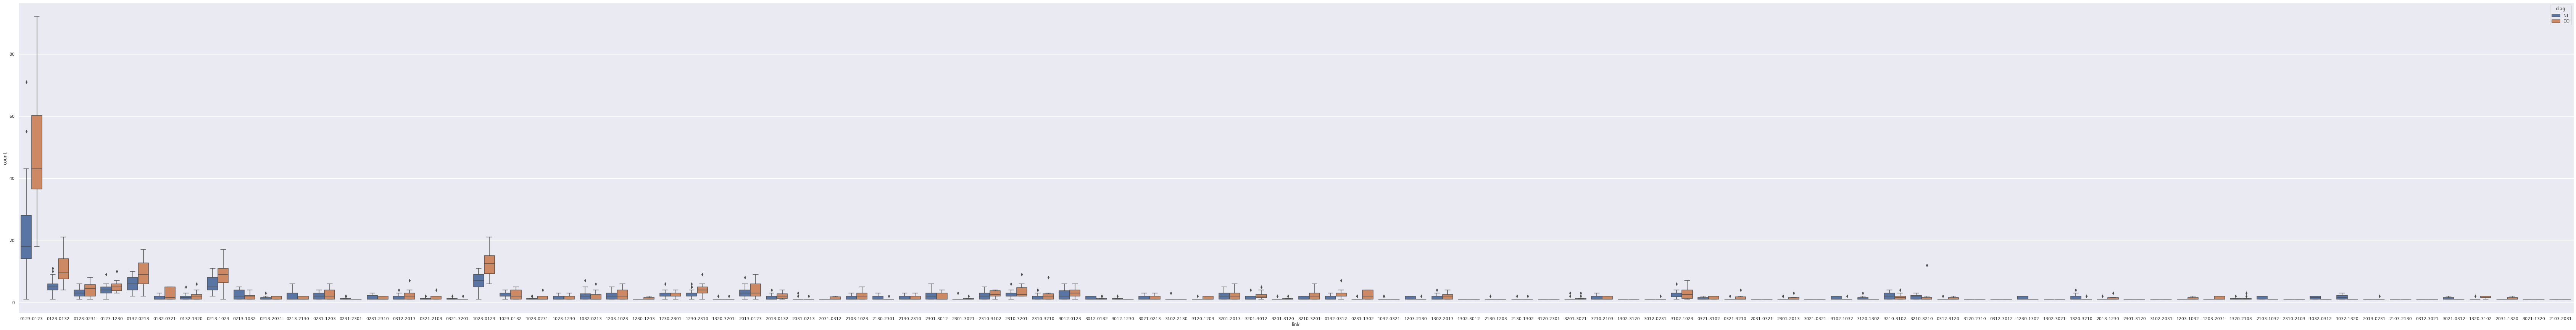

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(120,15)})

sns.boxplot(data=graphs_links, x="link", y="count", hue="diag")

# Normalización

In [ ]:
graphs_links

,ident,diag,pattern_source,pattern_target,count,link
1,1-,NT,0123,0123,5,0123-0123
2,1-,NT,0123,0132,5,0123-0132
3,1-,NT,0123,0231,4,0123-0231
4,1-,NT,0123,1230,2,0123-1230
5,1-,NT,0132,0213,10,0132-0213
...,...,...,...,...,...,...
2006,8-,DD,3201,3012,5,3201-3012
2007,8-,DD,3201,3021,1,3201-3021
2008,8-,DD,3201,3120,1,3201-3120
2009,8-,DD,3210,3102,2,3210-3102


In [ ]:
graphs_links['pattern_source'] = pd.Series(graphs_links['pattern_source']).astype(str).str.zfill(4)
graphs_links['pattern_target'] = pd.Series(graphs_links['pattern_target']).astype(str).str.zfill(4)
graphs_links

,ident,diag,pattern_source,pattern_target,count,link
1,1-,NT,0123,0123,5,0123-0123
2,1-,NT,0123,0132,5,0123-0132
3,1-,NT,0123,0231,4,0123-0231
4,1-,NT,0123,1230,2,0123-1230
5,1-,NT,0132,0213,10,0132-0213
...,...,...,...,...,...,...
2006,8-,DD,3201,3012,5,3201-3012
2007,8-,DD,3201,3021,1,3201-3021
2008,8-,DD,3201,3120,1,3201-3120
2009,8-,DD,3210,3102,2,3210-3102


In [ ]:
# subjects
subjects = graphs_links.ident.unique()
subjects

array(['1-', '10', '11', '12', '13', '14', '15', '16', '18', '19', '2-',
       '20', '21', '22', '23', '24', '25', '28', '29', '3-', '31', '32',
       '37', '38', '39', '40', '42', '43', '44', '45', '46', '47', '48',
       '49', '5-', '50', '51', '52', '54', '55', '56', '6-', '8-'],
      dtype=object)

In [ ]:
df_normal = pd.DataFrame()

for subject in subjects:
    # patterns of each subject
    subject_ident = graphs_links[graphs_links.ident == subject].ident
    subject_diag = graphs_links[graphs_links.ident == subject].diag
    subject_source = graphs_links[graphs_links.ident == subject].pattern_source
    subject_target = graphs_links[graphs_links.ident == subject].pattern_target
    
    subject_link = graphs_links['link'][graphs_links.ident == subject] 
    subject_count = graphs_links['count'][graphs_links.ident == subject]
    # normalize 
    counts = subject_count.values.reshape(-1,1)
    subject_normal = (counts / counts.sum()).round(3)
    
    temp = pd.DataFrame({'subject': subject_ident, 
                         'diag': subject_diag,
                         'pattern_source': subject_source,
                         'pattern_target': subject_target,
                         'link': subject_link, 
                         'count': subject_count, 
                         'normal_count': subject_normal.ravel()})
    df_normal = pd.concat([df_normal, temp])

df_normal

,subject,diag,pattern_source,pattern_target,link,count,normal_count
1,1-,NT,0123,0123,0123-0123,5,0.042
2,1-,NT,0123,0132,0123-0132,5,0.042
3,1-,NT,0123,0231,0123-0231,4,0.034
4,1-,NT,0123,1230,0123-1230,2,0.017
5,1-,NT,0132,0213,0132-0213,10,0.084
...,...,...,...,...,...,...,...
2006,8-,DD,3201,3012,3201-3012,5,0.023
2007,8-,DD,3201,3021,3201-3021,1,0.005
2008,8-,DD,3201,3120,3201-3120,1,0.005
2009,8-,DD,3210,3102,3210-3102,2,0.009


In [ ]:
nt_normalgroup = df_normal[df_normal.diag == 'NT']
dd_normalgroup = df_normal[df_normal.diag == 'DD']

dd_normalgroup

,subject,diag,pattern_source,pattern_target,link,count,normal_count
320,18,DD,0123,0123,0123-0123,35,0.340
321,18,DD,0123,0132,0123-0132,6,0.058
322,18,DD,0123,0231,0123-0231,3,0.029
323,18,DD,0132,0213,0132-0213,2,0.019
324,18,DD,0132,0312,0132-0312,1,0.010
...,...,...,...,...,...,...,...
2006,8-,DD,3201,3012,3201-3012,5,0.023
2007,8-,DD,3201,3021,3201-3021,1,0.005
2008,8-,DD,3201,3120,3201-3120,1,0.005
2009,8-,DD,3210,3102,3210-3102,2,0.009


In [ ]:
links = df_normal.link.unique()
links

array(['0123-0123', '0123-0132', '0123-0231', '0123-1230', '0132-0213',
       '0132-0321', '0132-1320', '0213-1023', '0213-1032', '0213-2031',
       '0213-2130', '0231-1203', '0231-2301', '0231-2310', '0312-2013',
       '0321-2103', '0321-3201', '1023-0123', '1023-0132', '1023-0231',
       '1023-1230', '1032-0213', '1203-1023', '1230-1203', '1230-2301',
       '1230-2310', '1320-3201', '2013-0123', '2013-0132', '2031-0213',
       '2031-0312', '2103-1023', '2130-2301', '2130-2310', '2301-3012',
       '2301-3021', '2310-3102', '2310-3201', '2310-3210', '3012-0123',
       '3012-0132', '3012-1230', '3021-0213', '3102-2130', '3120-1203',
       '3201-2013', '3201-3012', '3201-3120', '3210-3201', '0132-0312',
       '0231-1302', '1032-0321', '1203-2130', '1302-2013', '1302-3012',
       '2130-1203', '2130-1302', '3120-2301', '3201-3021', '3210-2103',
       '1302-3120', '3012-0231', '3102-1023', '0321-3102', '0321-3210',
       '2031-0321', '2301-2013', '3021-0321', '3102-1032', '3120

In [ ]:
#nt_normalgroup
df_normalgroup = pd.DataFrame()

for link in links:
    subjects_diag = nt_normalgroup['diag'][nt_normalgroup.link == link].unique()
    subjects_pattern_source = nt_normalgroup['pattern_source'][nt_normalgroup.link == link].unique()
    subjects_pattern_target = nt_normalgroup['pattern_target'][nt_normalgroup.link == link].unique()
    
    subjects_normalcount = nt_normalgroup['normal_count'][nt_normalgroup.link == link]
    sum_subjects_normalcount = subjects_normalcount.sum()
    mean_sum_group = (sum_subjects_normalcount / len(subjects_normalcount)).round(3)

    temp = pd.DataFrame({'diag': subjects_diag,
                         'link': link, 
                         'pattern_source': subjects_pattern_source,
                         'pattern_target': subjects_pattern_target,
                         'sum_normal_count': sum_subjects_normalcount, 
                         'mean_normal_count': mean_sum_group})
    df_normalgroup = pd.concat([df_normalgroup, temp])
    
df_normalgroup

,diag,link,pattern_source,pattern_target,sum_normal_count,mean_normal_count
0,NT,0123-0123,0123,0123,5.388,0.186
0,NT,0123-0132,0123,0132,1.282,0.046
0,NT,0123-0231,0123,0231,0.703,0.025
0,NT,0123-1230,0123,1230,1.101,0.038
0,NT,0132-0213,0132,0213,1.446,0.052
...,...,...,...,...,...,...
0,NT,3021-0312,3021,0312,0.036,0.012
0,NT,1320-3102,1320,3102,0.054,0.011
0,NT,2031-1320,2031,1320,0.024,0.008
0,NT,3021-1320,3021,1320,0.032,0.011


In [ ]:
## dd_normalgroup
for link in links:
    subjects_diag = dd_normalgroup['diag'][dd_normalgroup.link == link].unique()
    subjects_pattern_source = dd_normalgroup['pattern_source'][dd_normalgroup.link == link].unique()
    subjects_pattern_target = dd_normalgroup['pattern_target'][dd_normalgroup.link == link].unique()
    
    subjects_normalcount = dd_normalgroup['normal_count'][dd_normalgroup.link == link]
    sum_subjects_normalcount = subjects_normalcount.sum()
    mean_sum_group = (sum_subjects_normalcount / len(subjects_normalcount)).round(3)

    temp = pd.DataFrame({'diag': subjects_diag,
                         'link': link, 
                         'pattern_source': subjects_pattern_source,
                         'pattern_target': subjects_pattern_target,
                         'sum_normal_count': sum_subjects_normalcount, 
                         'mean_normal_count': mean_sum_group})
    df_normalgroup = pd.concat([df_normalgroup, temp])
    
df_normalgroup

,diag,link,pattern_source,pattern_target,sum_normal_count,mean_normal_count
0,NT,0123-0123,0123,0123,5.388,0.186
0,NT,0123-0132,0123,0132,1.282,0.046
0,NT,0123-0231,0123,0231,0.703,0.025
0,NT,0123-1230,0123,1230,1.101,0.038
0,NT,0132-0213,0132,0213,1.446,0.052
...,...,...,...,...,...,...
0,DD,3021-0312,3021,0312,0.013,0.007
0,DD,1320-3102,1320,3102,0.024,0.008
0,DD,2031-1320,2031,1320,0.017,0.006
0,DD,3021-1320,3021,1320,0.024,0.006


In [ ]:
df_normalgroup.to_csv(folder + 'mean_normal_count_v4.csv')

In [ ]:
test = df_normalgroup[df_normalgroup.pattern_source == "0123"]
test

,diag,link,pattern_source,pattern_target,sum_normal_count,mean_normal_count
0,NT,0123-0123,0123,0123,5.388,0.186
0,NT,0123-0132,0123,0132,1.282,0.046
0,NT,0123-0231,0123,0231,0.703,0.025
0,NT,0123-1230,0123,1230,1.101,0.038
0,DD,0123-0123,0123,0123,3.821,0.273
0,DD,0123-0132,0123,0132,0.816,0.058
0,DD,0123-0231,0123,0231,0.307,0.022
0,DD,0123-1230,0123,1230,0.343,0.029


## Graph

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import graphviz
import scipy 

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)

In [ ]:
# Se crea un grafo vacio
G = nx.DiGraph() # grafo en una sola dirección

# Añadir nodos
nodes = df_normalgroup.pattern_source.unique()
G.add_nodes_from(nodes)
print("nodes: ", G.nodes)

nodes:  ['0123', '0132', '0213', '0231', '0312', '0321', '1023', '1032', '1203', '1230', '1320', '2013', '2031', '2103', '2130', '2301', '2310', '3012', '3021', '3102', '3120', '3201', '3210', '1302']


In [ ]:
diags = df_normalgroup['diag'].unique()
diags

array(['NT', 'DD'], dtype=object)

diag:  NT


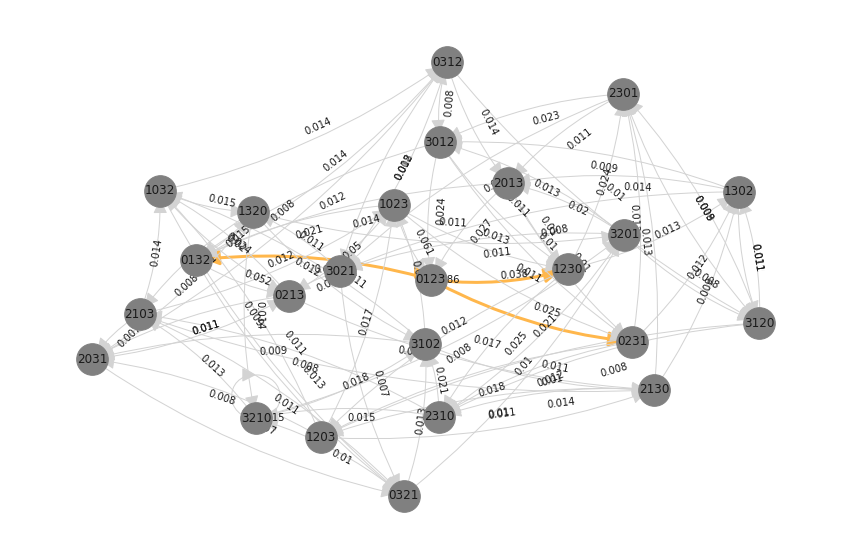

diag:  DD


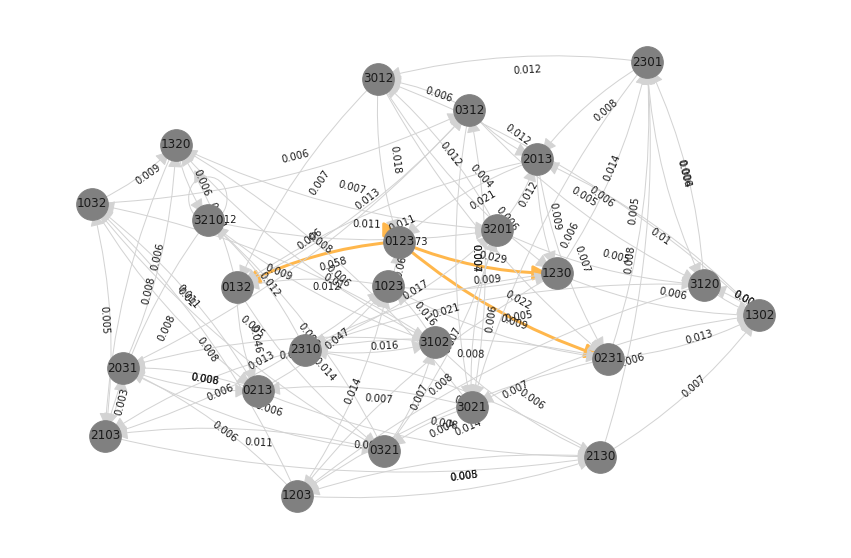

In [ ]:
diag_adjacency_matrices = {}

for diag in diags:
    print('diag: ', diag)
    
    # patterns of each subject
    data = df_normalgroup[df_normalgroup.diag == diag]
      
    # add edges
    for index, row in data.iterrows():
        G.add_edge(row["pattern_source"], row["pattern_target"], weight=row["mean_normal_count"])  
        
    # adjacency matrices
    #diag_adjacency_matrices[diag] = nx.to_numpy_matrix(G)
        
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if u == '0123']
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if u != '0123']

    # positions for all nodes - seed for reproducibility
    pos = nx.spring_layout(G, seed=100) 
    
    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='#808080')
    
    # node labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
    
    # edges
    # P: #FFB74C NT - #138D90 DD
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=3, edge_color='#FFB74C', 
                          arrows=True, arrowsize=30, connectionstyle='arc3,rad=0.1',
                          min_target_margin=1)
    nx.draw_networkx_edges(G, pos, edgelist=esmall, width=1, alpha=1, edge_color="lightgray",
                          arrows=True, arrowsize=30, connectionstyle='arc3,rad=0.1',
                          min_target_margin=1)
    
    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    weight_label_options = {"ec": "k", "fc": "white", "alpha": 0}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, bbox=weight_label_options,
                                 horizontalalignment='left', verticalalignment='center')

    ax = plt.gca()
    ax.margins(0.07)
    plt.axis("off")
    #title = 'normalized mean diagnosis: ' + diag
    #ax.set_title(title)
    name = 'figures/graph_'+ str(diag) +'.png'
    plt.savefig(folder + name, dpi=300)
    plt.show()

# Clasificador

No nos importa el gráfico del grafo sino sus pesos, ver si esos 4 pesos son un feature adecuado para discriminar. Dicho de otra manera, dada una persona y sus 4 pesos, ver si éstos están más cerca del promedio de los NT o de los D.

In [ ]:
df_normal

,subject,diag,pattern_source,pattern_target,link,count,normal_count
1,1-,NT,0123,0123,0123-0123,5,0.042
2,1-,NT,0123,0132,0123-0132,5,0.042
3,1-,NT,0123,0231,0123-0231,4,0.034
4,1-,NT,0123,1230,0123-1230,2,0.017
5,1-,NT,0132,0213,0132-0213,10,0.084
...,...,...,...,...,...,...,...
2006,8-,DD,3201,3012,3201-3012,5,0.023
2007,8-,DD,3201,3021,3201-3021,1,0.005
2008,8-,DD,3201,3120,3201-3120,1,0.005
2009,8-,DD,3210,3102,3210-3102,2,0.009


In [ ]:
df_normal_123 = df_normal[df_normal.pattern_source == "0123"]
print(df_normal_123.link.unique())

df_normal_123

['0123-0123' '0123-0132' '0123-0231' '0123-1230']


,subject,diag,pattern_source,pattern_target,link,count,normal_count
1,1-,NT,0123,0123,0123-0123,5,0.042
2,1-,NT,0123,0132,0123-0132,5,0.042
3,1-,NT,0123,0231,0123-0231,4,0.034
4,1-,NT,0123,1230,0123-1230,2,0.017
50,10,NT,0123,0123,0123-0123,21,0.167
...,...,...,...,...,...,...,...
1906,6-,DD,0123,1230,0123-1230,4,0.017
1957,8-,DD,0123,0123,0123-0123,62,0.286
1958,8-,DD,0123,0132,0123-0132,19,0.088
1959,8-,DD,0123,0231,0123-0231,1,0.005


In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df_normal_123[['link']])
df_normal_123['linklabel'] = le.transform(df_normal_123[['link']])

le.fit(df_normal_123[['diag']])
df_normal_123['diaglabel'] = le.transform(df_normal_123[['diag']])

df_normal_123

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-43-6a24132b82d3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normal_123['linklabel'] = le.transform(df_normal_123[['link']])
<ipython-input-43-6a24132b82d3>:8: SettingWithCopyWarning: 
A value is trying t

,subject,diag,pattern_source,pattern_target,link,count,normal_count,linklabel,diaglabel
1,1-,NT,0123,0123,0123-0123,5,0.042,0,1
2,1-,NT,0123,0132,0123-0132,5,0.042,1,1
3,1-,NT,0123,0231,0123-0231,4,0.034,2,1
4,1-,NT,0123,1230,0123-1230,2,0.017,3,1
50,10,NT,0123,0123,0123-0123,21,0.167,0,1
...,...,...,...,...,...,...,...,...,...
1906,6-,DD,0123,1230,0123-1230,4,0.017,3,0
1957,8-,DD,0123,0123,0123-0123,62,0.286,0,0
1958,8-,DD,0123,0132,0123-0132,19,0.088,1,0
1959,8-,DD,0123,0231,0123-0231,1,0.005,2,0


In [ ]:
df_normal_123.to_csv(folder + 'df_normal_123.csv')

In [ ]:
df_features = pd.DataFrame()

for subject in subjects:
    subject_ident = df_normal_123[df_normal_123.subject == subject].subject
    subject_diag = df_normal_123[df_normal_123.subject == subject].diaglabel
    subject_linklabel = df_normal_123[df_normal_123.subject == subject].linklabel
    subject_normalcount = df_normal_123[df_normal_123.subject == subject].normal_count
        
    temp = pd.DataFrame({'subject': subject_ident, 
                         'diag': subject_diag,
                         'linklabel': subject_linklabel, 
                         'normal_count': subject_normalcount})
    temp = temp.pivot_table('normal_count', ['subject', 'diag'], 'linklabel')

    df_features = pd.concat([df_features, temp])
    
df_features = df_features.fillna(0)
df_features

,linklabel,0,1,2,3
subject,diag,,,,
1-,1,0.042,0.042,0.034,0.017
10,1,0.167,0.048,0.040,0.040
11,1,0.375,0.000,0.018,0.089
12,1,0.372,0.027,0.020,0.061
13,1,0.197,0.070,0.042,0.028
14,1,0.159,0.047,0.028,0.037
15,1,0.163,0.039,0.039,0.039
16,1,0.286,0.020,0.041,0.061
18,0,0.340,0.058,0.029,0.000


In [ ]:
df_features.to_csv(folder + 'df_features.csv')

In [ ]:
df_features.describe()

linklabel,0,1,2,3
count,43.000000,43.000000,43.000000,43.000000
mean,0.214163,0.048791,0.023488,0.033581
std,0.106561,0.017632,0.010418,0.016638
min,0.010000,0.000000,0.000000,0.000000
25%,0.146000,0.039000,0.016500,0.023500
50%,0.199000,0.048000,0.024000,0.037000
75%,0.286000,0.057500,0.029500,0.040000
max,0.452000,0.088000,0.042000,0.089000


In [ ]:
df_normal_123.rename(columns = {'normal_count':'Frequency'}, inplace = True)
df_normal_123

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,subject,diag,pattern_source,pattern_target,link,count,Frequency,linklabel,diaglabel
1,1-,NT,0123,0123,0123-0123,5,0.042,0,1
2,1-,NT,0123,0132,0123-0132,5,0.042,1,1
3,1-,NT,0123,0231,0123-0231,4,0.034,2,1
4,1-,NT,0123,1230,0123-1230,2,0.017,3,1
50,10,NT,0123,0123,0123-0123,21,0.167,0,1
...,...,...,...,...,...,...,...,...,...
1906,6-,DD,0123,1230,0123-1230,4,0.017,3,0
1957,8-,DD,0123,0123,0123-0123,62,0.286,0,0
1958,8-,DD,0123,0132,0123-0132,19,0.088,1,0
1959,8-,DD,0123,0231,0123-0231,1,0.005,2,0


In [ ]:
# subjects
subjects_nt = dataset[dataset.diag == "NT"].ident.unique()
print(subjects_nt)

subjects_dd = dataset[dataset.diag == "DD"].ident.unique()
print(subjects_dd)

['1-' '10' '11' '12' '13' '14' '15' '16' '19' '2-' '20' '21' '22' '28'
 '3-' '31' '32' '37' '39' '40' '42' '43' '44' '45' '47' '48' '49' '5-'
 '50']
['18' '23' '24' '25' '29' '38' '46' '51' '52' '54' '55' '56' '6-' '8-']


In [ ]:
# table NT == 1
df_features_NT = pd.DataFrame()

for subject in subjects_nt:
    subject_ident = df_normal_123[df_normal_123.subject == subject].subject
    subject_diag = df_normal_123[df_normal_123.subject == subject].diaglabel
    subject_linklabel = df_normal_123[df_normal_123.subject == subject].linklabel
    subject_normalcount = df_normal_123[df_normal_123.subject == subject].Frequency
        
    temp = pd.DataFrame({'subject': subject_ident, 
                         'diag': subject_diag,
                         'linklabel': subject_linklabel, 
                         'normal_count': subject_normalcount})
    temp = temp.pivot_table('normal_count', ['subject', 'diag'], 'linklabel')

    df_features_NT = pd.concat([df_features_NT, temp])
    
df_features_NT = df_features_NT.fillna(0)
df_features_NT.describe()

linklabel,0,1,2,3
count,29.000000,29.000000,29.000000,29.000000
mean,0.185793,0.044207,0.024241,0.037966
std,0.104891,0.017191,0.010626,0.016380
min,0.010000,0.000000,0.000000,0.010000
25%,0.114000,0.037000,0.018000,0.032000
50%,0.159000,0.045000,0.025000,0.038000
75%,0.271000,0.056000,0.030000,0.041000
max,0.452000,0.083000,0.042000,0.089000


In [ ]:
# table DD == 0
df_features_DD = pd.DataFrame()

for subject in subjects_dd:
    subject_ident = df_normal_123[df_normal_123.subject == subject].subject
    subject_diag = df_normal_123[df_normal_123.subject == subject].diaglabel
    subject_linklabel = df_normal_123[df_normal_123.subject == subject].linklabel
    subject_normalcount = df_normal_123[df_normal_123.subject == subject].Frequency
        
    temp = pd.DataFrame({'subject': subject_ident, 
                         'diag': subject_diag,
                         'linklabel': subject_linklabel, 
                         'normal_count': subject_normalcount})
    temp = temp.pivot_table('normal_count', ['subject', 'diag'], 'linklabel')

    df_features_DD = pd.concat([df_features_DD, temp])
    
df_features_DD = df_features_DD.fillna(0)
df_features_DD.describe()

linklabel,0,1,2,3
count,14.000000,14.000000,14.000000,14.000000
mean,0.272929,0.058286,0.021929,0.024500
std,0.086458,0.014964,0.010179,0.013592
min,0.102000,0.032000,0.005000,0.000000
25%,0.213500,0.052250,0.015750,0.017250
50%,0.290500,0.054500,0.023000,0.027500
75%,0.331750,0.060250,0.028500,0.031750
max,0.426000,0.088000,0.040000,0.045000


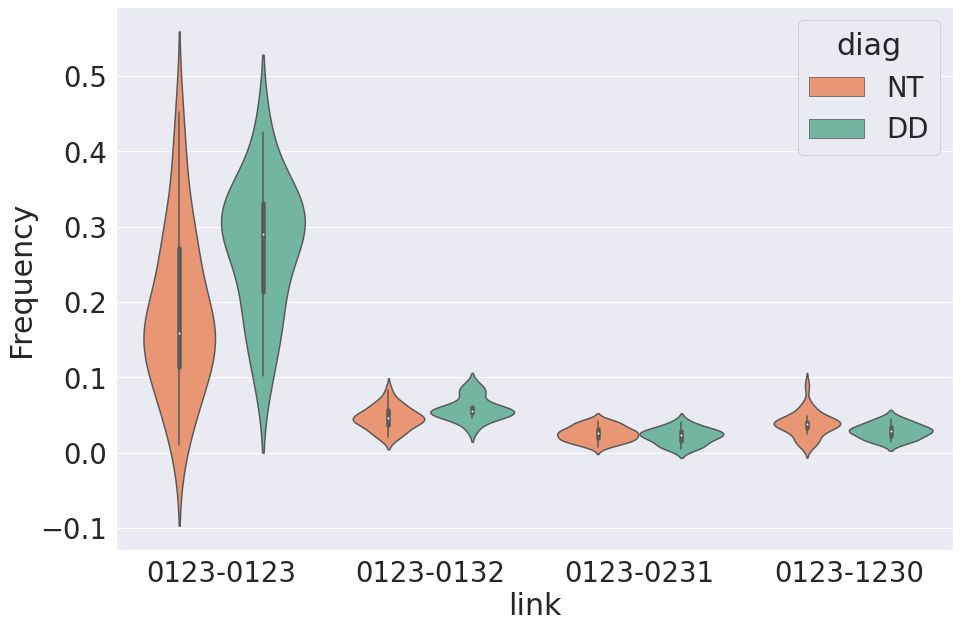

In [ ]:
palette = sns.color_palette("Set2",n_colors=2)
palette.reverse()
sns.set(font_scale = 2.5) #1.5

sns.violinplot(data=df_normal_123, x="link", y="Frequency", hue="diag", palette=palette) #inner="stick"
plt.savefig(folder + 'figures/violinplot.png', dpi=300)

In [ ]:
df_features = df_features.reset_index()

df_features = df_features.rename(columns = {0: '0123-0123',
                                            1: '0123-0132',
                                            2: '0123-0231',
                                            3: '0123-1230'})

df_features.sample(3)

linklabel,subject,diag,0123-0123,0123-0132,0123-0231,0123-1230
41,6-,0,0.333,0.061,0.009,0.017
23,38,0,0.182,0.080,0.023,0.000
32,48,1,0.202,0.025,0.034,0.034


In [ ]:
df_features.head()

linklabel,subject,diag,0123-0123,0123-0132,0123-0231,0123-1230
0,1-,1,0.042,0.042,0.034,0.017
1,10,1,0.167,0.048,0.040,0.040
2,11,1,0.375,0.000,0.018,0.089
3,12,1,0.372,0.027,0.020,0.061
4,13,1,0.197,0.070,0.042,0.028


In [ ]:
X = df_features[['0123-0123', '0123-0132', '0123-0231', '0123-1230']].values 
y = df_features[['diag']].values

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#clf = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=50)
#clf = GaussianNB() #Naive Bayes
clf = DecisionTreeClassifier(max_depth=4) #max_depth=2 / 4
#clf = KNeighborsClassifier()
#clf = SVC(kernel='linear') # Support Vector Machine
#clf = RandomForestClassifier()

clf.fit(X, y)

DecisionTreeClassifier(max_depth=4)

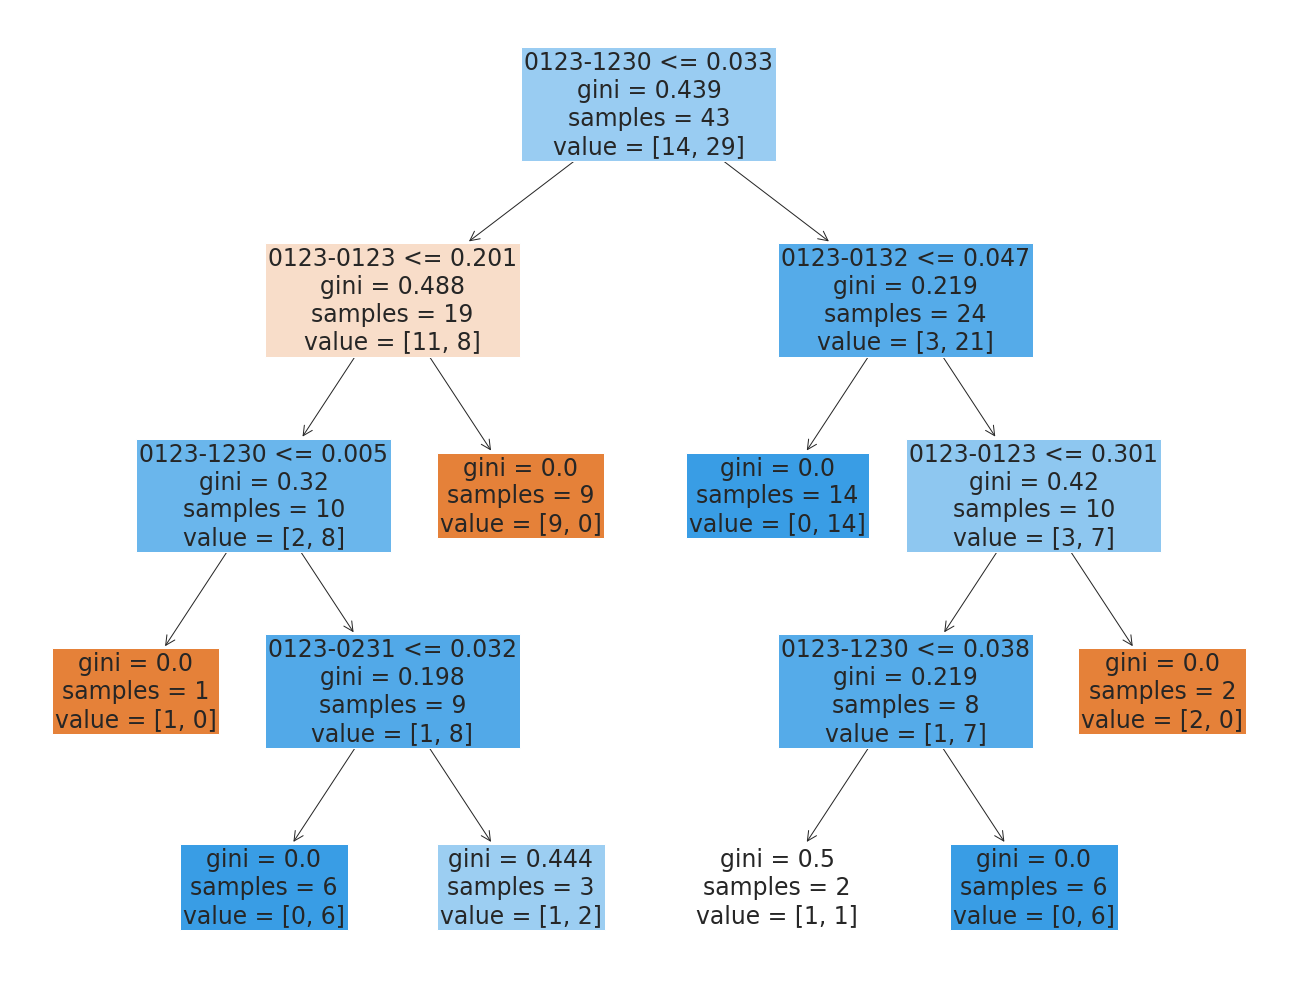

In [ ]:
fig = plt.figure(figsize=(23,18))
_ = plot_tree(clf, feature_names=['0123-0123', '0123-0132', '0123-0231', '0123-1230'], filled=True)
plt.savefig(folder + 'figures/dt_tree_depth2.png', dpi=300)

In [ ]:
features = ['0123-0123', '0123-0132', '0123-0231', '0123-1230'] #['0', '1', '2', '3']

import itertools

features_interactions = list(itertools.combinations(features, 2)) # we generate all the pairwise feature combinations
features_interactions

[('0123-0123', '0123-0132'),
 ('0123-0123', '0123-0231'),
 ('0123-0123', '0123-1230'),
 ('0123-0132', '0123-0231'),
 ('0123-0132', '0123-1230'),
 ('0123-0231', '0123-1230')]

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


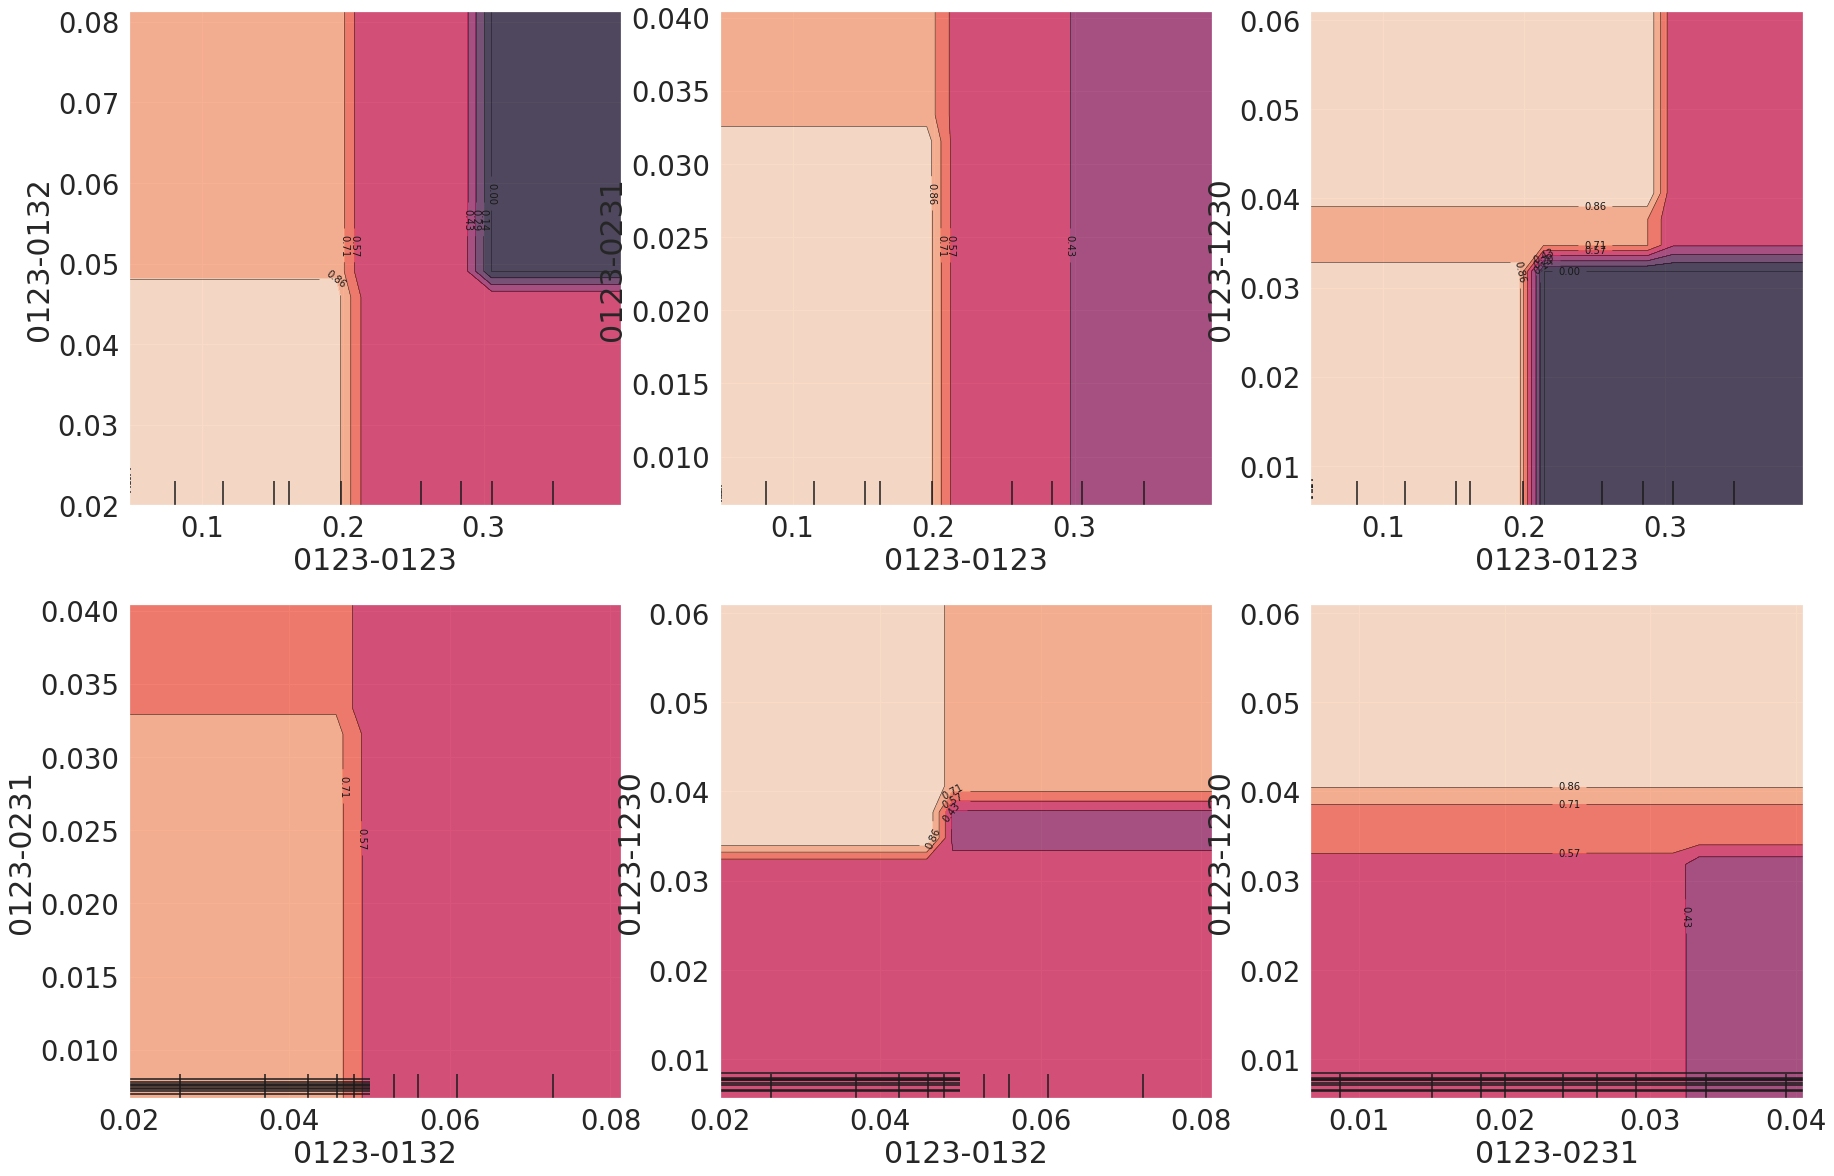

In [ ]:
from sklearn.inspection import partial_dependence, plot_partial_dependence, permutation_importance

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
plt.rc('font', **font)

fig3, ax3 = plt.subplots(figsize=(30, 20))

#plt.rc('axes', labelsize=22) #18
#plt.rc('xtick', labelsize=22)
#plt.rc('ytick', labelsize=22)

rf_2d_pdp = plot_partial_dependence(
        clf, 
        X, 
        features_interactions, 
        kind='average', 
        grid_resolution=20,
        feature_names=['0123-0123', '0123-0132', '0123-0231', '0123-1230'],
    ax=ax3)
#plt.savefig('dt_pdp.png', dpi=300)

In [ ]:
y_predict = clf.predict(X)

In [ ]:
from sklearn.metrics import classification_report

cr = classification_report(y_true=y, y_pred=y_predict)
print(cr) 

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.97      0.97      0.97        29

    accuracy                           0.95        43
   macro avg       0.95      0.95      0.95        43
weighted avg       0.95      0.95      0.95        43



In [ ]:
le.inverse_transform([0, 1])

array(['DD', 'NT'], dtype=object)

*   max_depth=2 / acc = 0.86 
*   max_depth=3 / acc = 0.91
*   max_depth=4 / acc = 1.00 